# Iceberg Classifier Challenge
Let's predict whether an image is a ship or an iceberg.

## About the Data
The remote sensing systems used to detect icebergs are housed on satellites over 600 kilometers above the Earth. <b>The Sentinel-1 satellite constellation is used to monitor Land and Ocean</b>. Orbiting 14 times a day, <b>the satellite captures images of the Earth's surface at a given location</b>, at a given instant in time. The C-Band radar operates at a frequency that "sees" through darkness, rain, cloud and even fog. Since it emits it's own energy source it can capture images day or night.

<b>Satellite radar works in much the same way as blips on a ship or aircraft radar. It bounces a signal off an object and records the echo, then that data is translated into an image</b>. An object will appear as a bright spot because it reflects more radar energy than its surroundings, but strong echoes can come from anything solid - land, islands, sea ice, as well as icebergs and ships. The energy reflected back to the radar is referred to as backscatter.

<img style="height:300px; width: 800px" src="https://storage.googleapis.com/kaggle-media/competitions/statoil/NM5Eg0Q.png" />

<b>The data has two channels:</b> <b>HH</b> (transmit/receive horizontally) and <b>HV</b> (transmit horizontally and receive vertically). This can play an important role in the object characteristics, since objects tend to reflect energy differently. Easy classification examples are see below. These objects can be visually classified. But in an image with hundreds of objects, is very hard to classified. 

#### Easy to classify
<img style="height:200px; width: 700px" src="https://storage.googleapis.com/kaggle-media/competitions/statoil/8ZkRcp4.png" />

<img style="height:200px; width: 700px" src="https://storage.googleapis.com/kaggle-media/competitions/statoil/M8OP2F2.png" />

#### More challenging objects
Here we see challenging objects to classify.  Is it a Ship or is it an Iceberg? 
<img style="height:200px; width: 700px" src="https://storage.googleapis.com/kaggle-media/competitions/statoil/AR4NDrK.png" />

<img style="height:200px; width: 700px" src="https://storage.googleapis.com/kaggle-media/competitions/statoil/nXK6Vdl.png" />

In [1]:
# Graphs and math
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg

# For 3D graphs
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# For CNN Model
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# System check
from subprocess import check_output
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


The first section of this notebook we are going to do in depth analysis to further understand the data. Next we'll going to create Convolutional neural network (CNN) using Keras, which is higher level library which operators over either TensorFlow or Theano.

## Analysis 

In [2]:
path = "data/processed/"
train_original = pd.read_json(f'{path}train.json')
test_original = pd.read_json(f'{path}test.json')

In [3]:
# Easy reload
train = train_original.copy()
test = test_original.copy()

In [4]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


<b>band_1</b> = horizontal polarization channel<br>
<b>band_2</b> = vertical polarization channel<br>

is_iceberg<b>[0]</b> = <b>Ship</b><br>
is_iceberg<b>[1]</b> = <b>Iceberg</b>

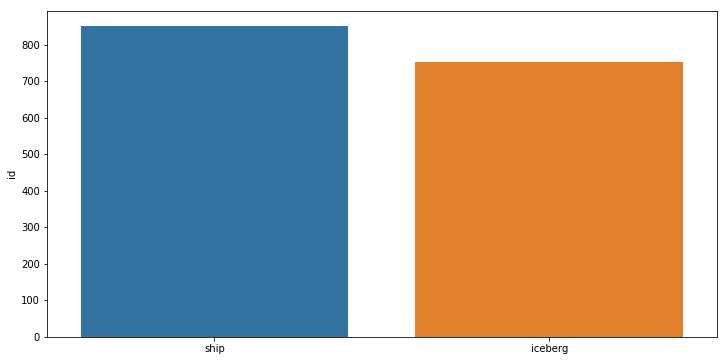

In [5]:
f,ax = plt.subplots(1,1,figsize=(12,6))
sns.barplot(x=['ship','iceberg'],y=train.groupby(['is_iceberg'],as_index=False).count()['id'])
plt.show()

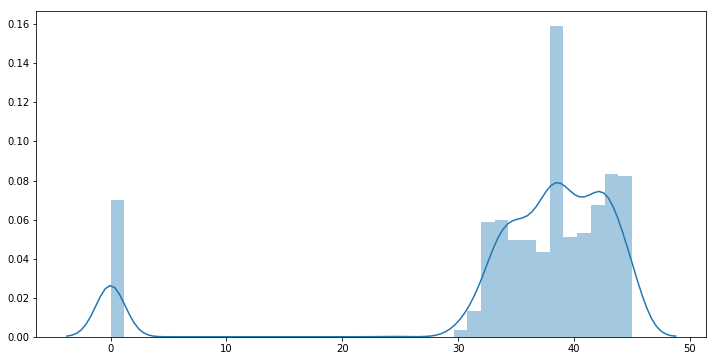

In [6]:
f,ax = plt.subplots(1,1,figsize=(12,6))
angles = [int(float(t)) if t != 'na' else 0 for t in train['inc_angle']]
train['intangle'] = angles
sns.distplot(angles)
plt.show()

### Why use color composite?
* Color composition might allow us to identify different characteristics of images
* Of course brightness of the images is effected by incidence angle, which we'll take a look later on
* In conclusion after color composition was that icebergs are showing more coherent and similar patterns within themselves where as ships are varying more

In [7]:
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))


        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [8]:
# Trained with data about rgb
rgb_train = color_composite(train)
rgb_train.shape

(1604, 75, 75, 3)

In [9]:
# Test with data about rgb
rgb_test = color_composite(test)
rgb_test.shape

(8424, 75, 75, 3)

In [10]:
# Let's show a random ship after applied color composite
def show_ships(rgb_data):
    print('Looking at random ships')
    ship = np.random.choice(np.where(train.is_iceberg == 0)[0], 9)
    fig = plt.figure(1, figsize = (12,12))
    for i in range(9):
        ax = fig.add_subplot(3,3,i+1)
        arr = rgb_data[ship[i], :, :]
        ax.imshow(arr)
    plt.show()

Looking at random ships


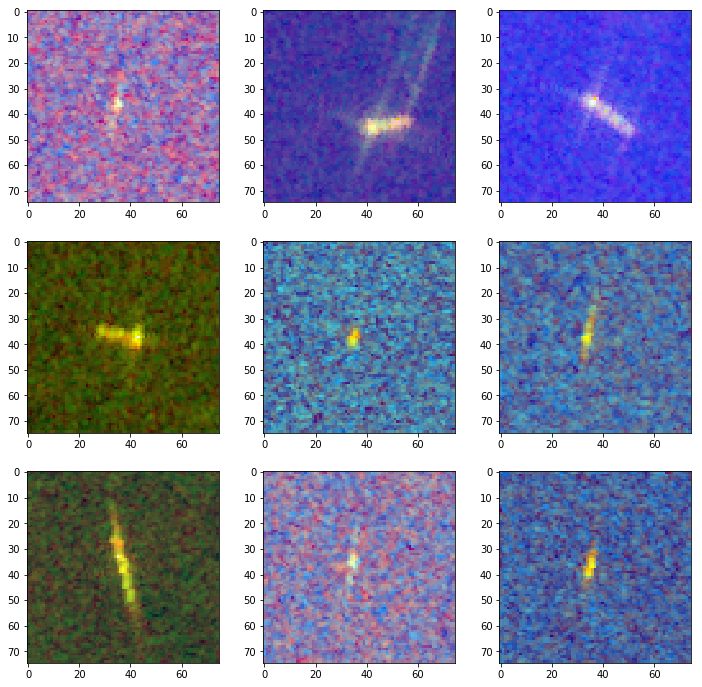

In [11]:
show_ships(rgb_data=rgb_train)

In [12]:
def show_iceberg(rgb_data):
    print('Looking at random icebergs')
    ice = np.random.choice(np.where(train.is_iceberg ==1)[0], 9)
    fig = plt.figure(200,figsize=(12,12))
    for i in range(9):
        ax = fig.add_subplot(3,3,i+1)
        arr = rgb_data[ice[i], :, :]
        ax.imshow(arr)
    plt.show()

Looking at random icebergs


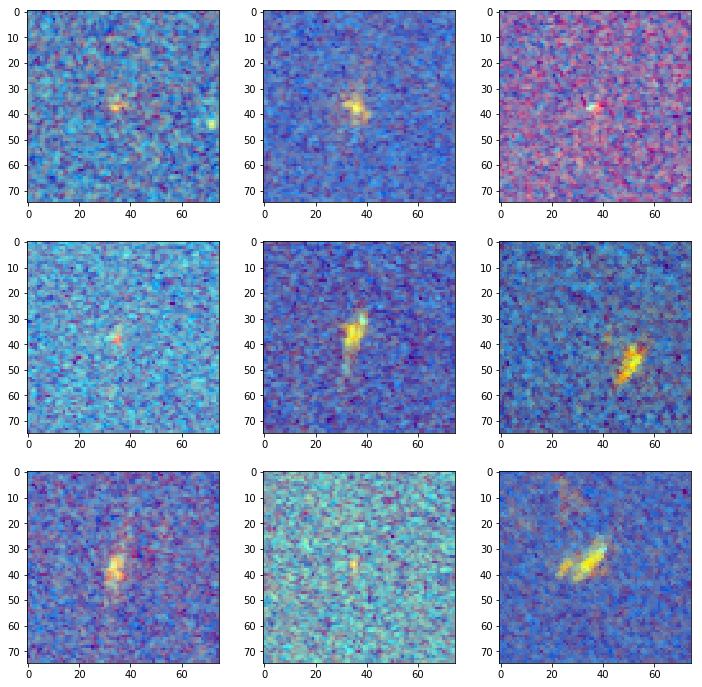

In [13]:
show_iceberg(rgb_data=rgb_train)

Let's give label to the image we are plotting.

In [14]:
group_data = train.copy()

In [15]:
def agg_group(data):
    agg_df = data.groupby('inc_angle').agg({"is_iceberg": [len, np.sum]}).sort_values([('is_iceberg', 'len')], ascending=False)
    return agg_df[0:20]

In [16]:
agg_g = agg_group(group_data)
agg_g

is_iceberg    
                 len sum
inc_angle               
na               133   0
34.4721           23  23
42.5591           16  16
36.1061           15  15
33.6352           15  15
39.234            13  13
38.4755           11  11
39.2166           11  11
39.9784           11  11
45.2814           11  11
34.4709           10  10
42.559            10  10
45.2859           10  10
40.7118            9   9
40.7129            9   9
39.2325            9   9
34.4718            9   9
37.6877            9   9
38.4591            9   9
35.7863            9   0

In [17]:
train.drop('intangle',axis=1, inplace=True)

In [18]:
def plot_bands(df, ia):
    df = df[df['inc_angle'] == ia]
    i = int(np.sqrt(len(df))//1 * 2)
    j = int(2*len(df) // i + 1)
    fig = plt.figure(1, figsize=(24,24))
    grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
    for i, (band1, band2, id_num, inc_angle, iceberg) in enumerate(df.values):
        # plot band 1
        ax = grid[(i*2)]
        band1_sample = band1
        band1_sample = np.array(band1_sample).reshape(75, 75)
        ax.imshow(band1_sample / 75.)
        ax.text(10, 5, 'Id: %s %s' % (id_num, "Band_1"), color='k', backgroundcolor='red', alpha=0.8)
        ax.text(10, 11, 'inc_angle: (%.4f)' % inc_angle, color='w', backgroundcolor='k', alpha=0.8)
        ax.text(10, 16, 'Is Iceberg: %s' % iceberg, color='k', backgroundcolor='w', alpha=0.8)
        ax.axis('on')
        # plot band 2
        ax = grid[(i*2)+1]
        band2_sample = band2
        band2_sample = np.array(band2_sample).reshape(75, 75)
        ax.imshow(band2_sample / 75.)
        ax.text(10, 5, 'Id: %s %s' % (id_num, "Band_2"), color='k', backgroundcolor='red', alpha=0.8)
        ax.text(10, 11, 'inc_angle: (%.4f)' % inc_angle, color='w', backgroundcolor='k', alpha=0.8)
        ax.text(10, 16, 'Is Iceberg: %s' % iceberg, color='k', backgroundcolor='w', alpha=0.8)
        ax.axis('on')

In [19]:
combined = pd.concat([train, test])

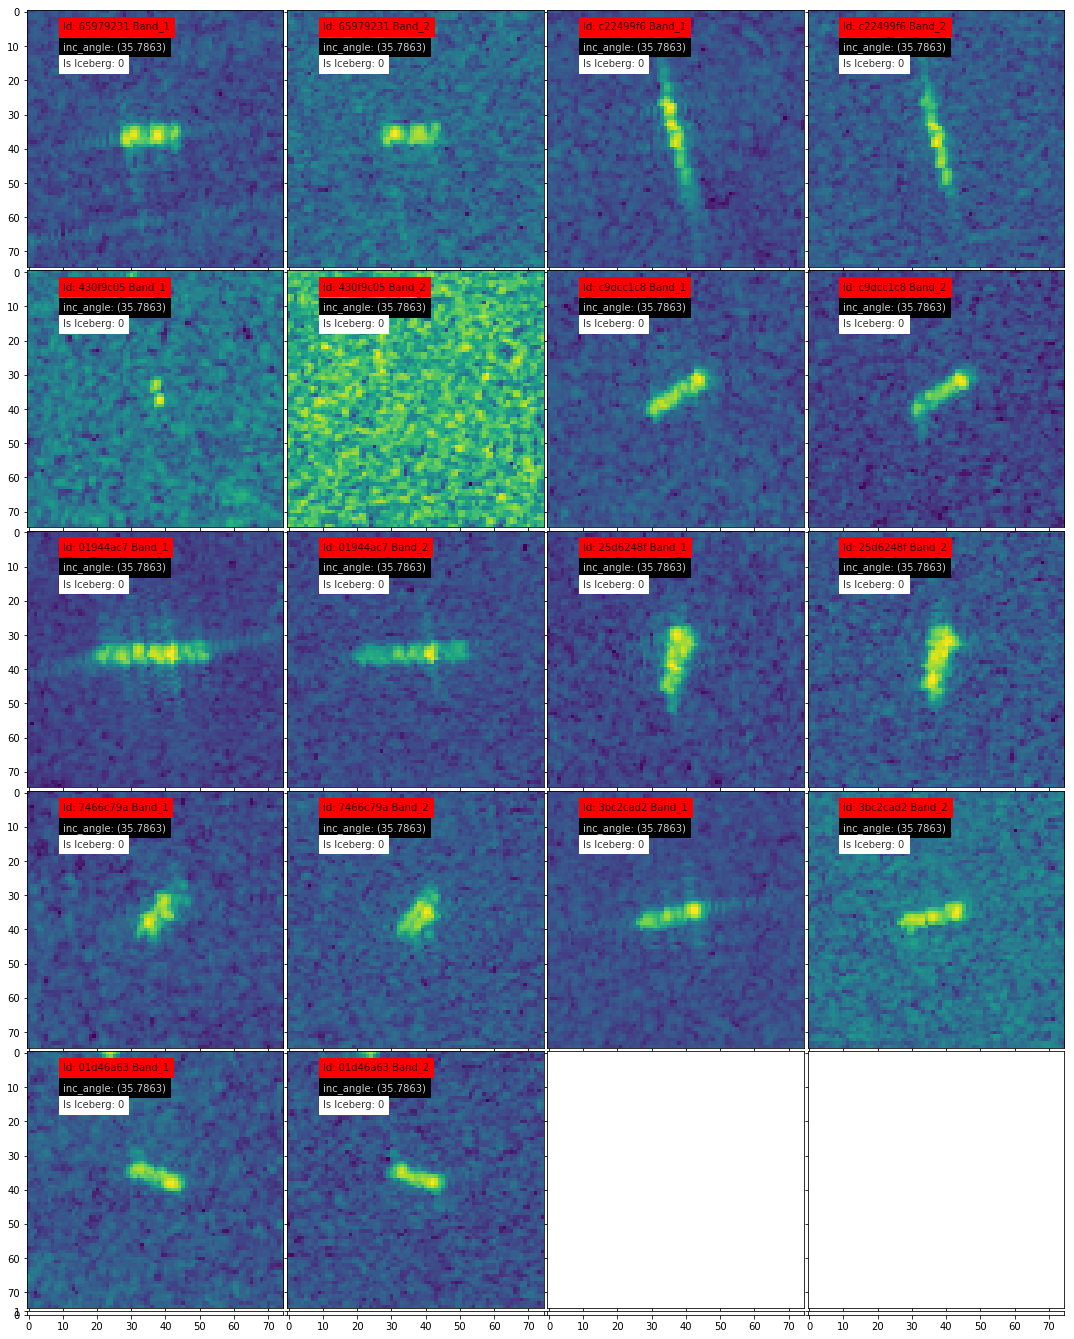

In [20]:
plot_bands(train, 35.7863)
plt.show()

### Plotly 3D
We have now explored the images in 2D, let's see in 3D.


In [21]:
#Take a look at a iceberg in 3D
def plot_3d_iceberg(c, name):
    data = [
        go.Surface(z = c)
    ]
    
    layout = go.Layout(title = name, autosize = False, width = 500, height = 500,
                      margin = dict(l=65, r=50, b=65, t=90))
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)


In [22]:
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

### Let's show both 2D and 3D side by side


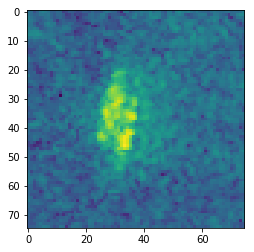

In [23]:
plt.figure()
arr = X_band_1[12, :, :]
plt.imshow(arr) 
plt.show() 

In [24]:
plot_3d_iceberg(X_band_1[12,:,:], 'iceberg')

As you the shape of the iceberg is going to be like a mountain as shown in here.  Likewise, the shape of the shipe is going to be like a point.

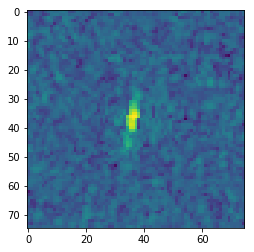

In [25]:
plt.figure()
arr = X_band_1[18, :, :]
plt.imshow(arr) 
plt.show() 

In [26]:
# take a look at ship in 3D
plot_3d_iceberg(X_band_1[18,:,:], 'Ship')

### CNN Keras Model
Now let's do the fun part of this notebook, the CNN model. This is a simplistic model that should give us reasonable results. It is not well tuned model and there are plenty of options and changes we can try to improve the prediction/classifying correct image.

In a nutshell, CNN are multi-layer neural networks - sometimes up to 17 or more layers - that assume the input data to be images.

<img src="http://adventuresinmachinelearning.com/wp-content/uploads/2017/04/CNN-example-block-diagram.jpg" />

Models in Keras can come in two forms, Sequential and via the Functional API. In our model we'll going to use the Sequential. It allows us to easily stack sequential layers of the network in order from input to output. The Functional API is more about building complicated architectures.

The first line declares the model type as Sequential().
```Python
    model = Sequential()
```

Next, we add a 2D convolutional layer to process the 2D iceberg input images. The first argument passed to the <b>Conv2D()</b> layer function is the number of output channels - in this case we have 64 output channels. The next input is the <b>kernel_size,</b>which in this case we have chosen to be a 5x5 moving window, followed by the strides in the x and y directions (1,1). Next, the activation function is a <b>rectified linear unit</b>, finally we have to supply the model with the size of the input to the layer.
```Python
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), strides = (1,1), activation='relu', input_shape=(75, 75, 3)))
```

Next, we add a 2D max pooling layer, we simply specify the size of the pooling in the x and y directions - in this case (2,2) and apply the strides.
```Python
    cnn_model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
```

Lastly, we add dropout, which allow us to prevent over-fitting while training model. Best practice, if chose >.2 we need more epoch to train our data.
```Python
    cnn_model.add(Dropout(0.1))
```

Next, we add few convolutional + max pooling layers, with 128, 128, and 64 output channels.
```Python
    ...
    ...
```

Now that we've built our convolutional layers, we want to flatten the output from these to enter our fully connected layers.
```Python
    # Flatten the data for upcoming dense layers
    cnn_model.add(Flatten())
```

The next few lines declare our fully connected layers - using the Dense() later in Keras.

In [27]:
# create model
def Model():
    # suquential
    cnn_model = Sequential()
    
    # First layer
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), strides = (1,1), activation='relu', input_shape=(75, 75, 3)))
    cnn_model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
    cnn_model.add(Dropout(0.1))
    
    # Second Layer
    cnn_model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    cnn_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    cnn_model.add(Dropout(0.2))
    
    # Third Layer
    cnn_model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
    cnn_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    cnn_model.add(Dropout(0.2))
    
    # Fourth Layer
    cnn_model.add(Conv2D(64, kernel_size = (3,3), activation ='relu'))
    cnn_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
    cnn_model.add(Dropout(0.2))
    
    # Flatten the data for upcoming dense layers
    cnn_model.add(Flatten())
    
    # Dense layer 1
    cnn_model.add(Dense(512))
    cnn_model.add(Activation('relu'))
    cnn_model.add(Dropout(0.2))
    
    # Dense layer 2
    cnn_model.add(Dense(256))
    cnn_model.add(Activation('relu'))
    cnn_model.add(Dropout(0.2))
    
    # sigmoid layer
    cnn_model.add(Dense(1))
    cnn_model.add(Activation('sigmoid'))
    
    # Keras supplies many optimisers - in this case we'll use the Adam optimizer
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    # For the loss function we will use the standard cross-entropy 
    cnn_model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                     metrics = ['accuracy'])
    # return the summary of the model
    cnn_model.summary()
    return cnn_model
    
    

### Set Callbacks
A callback is a set of functions to be applied at given stages of the training procedure. I used EarlyStopping to prevent overtraining.

In [28]:
# EarlyStopping stops training when model does not improve after epochs. interval can be configured with patience.
def callbacks(filepath, patience = 3):
    earlyStop = EarlyStopping('val_loss', patience=patience, mode = 'min')
    saveModel = ModelCheckpoint(filepath, save_best_only=True)
    return [earlyStop, saveModel]

In [29]:
model_name = ".current_model.hdf5"
callbacks = callbacks(model_name, patience=5)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
#X = train.iloc[:, :-1]

In [32]:
#target_train=train['is_iceberg']


Split our data into train and test sets

In [33]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

In [34]:
batch_size = 50
epochs = 10
verbose = 2

cnn_model = Model()
cnn_model.fit(X_train_cv, y_train_cv, batch_size = batch_size, epochs = epochs,
             verbose = verbose, validation_data = (X_valid, y_valid),
             callbacks = callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Let's see how our model did for the train

In [35]:
score = cnn_model.evaluate(X_valid, y_valid, verbose=1)
print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))

401/401 [==============================] - 3s 7ms/step
Test loss: 0.36662255335329774
Test accuracy: 0.8354114717676158
